In [ ]:
# importação das bibliotecas necessárias

import pandas as pd
import numpy as np
from numpy import mean
from numpy import std
from matplotlib import pyplot as plt
from matplotlib import pyplot
from sklearn.model_selection import KFold
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, AvgPool2D, BatchNormalization, Reshape
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler
from sklearn.metrics import accuracy_score

# Importação do Dataset

Estou me baseando fashion: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

Estou me baseando digitos: https://machinelearningmastery.com/how-to-develop-a-convolutional-neural-network-from-scratch-for-mnist-handwritten-digit-classification/

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive")

# Carregamento dos dados

In [ ]:
#Importando o dataset
def load_dataset():

  train = pd.read_csv('/content/gdrive/My Drive/IA - Karina/EP 1/Dataset/fashion-mnist_train.csv')
  test = pd.read_csv('/content/gdrive/My Drive/IA - Karina/EP 1/Dataset/fashion-mnist_test.csv')

  # casting para deixar todos os valores no mesmo formato, float32
  # alguns métodos das bibliotecas utilizadas tem esse tipo como default
  train_data = np.array(train, dtype = 'float32')
  test_data = np.array(test, dtype='float32')

  # no dataset fashion-mnist a classe encontra-se na primeira label, sendo assim abaixo ela é separada para
  # definir as variáveis das classes.
  x_train = train_data[:,1:]

  y_train = train_data[:,0]

  x_test= test_data[:,1:]

  y_test=test_data[:,0]

  # normalizacao sera feita abaixo
  # a normalizacao vai reescalar dos tons de cinza para o intervalo de 0 e 1
  # cada pixel possui varia de 0 a 255, representando os tons de branco até cinza/preto
    # todos os valores foram divididos por 255 para normalizá-los no intervalo de 0 e 1
  x_train = x_train / 255.0

  x_test = x_test / 255.0

  # todas as imagens são no formato de 28x28 pixels, shape das imagens
  image_rows = 28
  image_cols = 28
  image_shape = (image_rows,image_cols,1)

  # estamos trabalhando com imagens de 28x28 pixels em tons de branco a cinza em diferentes escalas
  # tendo isso, essa imagem é tranposta em um único array
  x_train = x_train.reshape(x_train.shape[0],*image_shape)
  x_test = x_test.reshape(x_test.shape[0],*image_shape)

  # a classe possui 10 classes (0 a 9) representados por integers
  # com isso podemos transformá-lo em uma matriz binária de 10 elementos a partir do
  # método one hot encoding equivalente ao to_categorical da biblioteca keras aplicada
  y_train = to_categorical(y_train)
  y_test = to_categorical(y_test)

  return x_train, y_train, x_test, y_test

In [ ]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x, verbose=0)
styles=[':','-.','--','-',':','-.','--','-',':','-.','--','-'] # estilos de desenhos de linhas para os gráficos que serão construídos

Abaixo será feito o carregamento dos dados:

In [ ]:
x_train, y_train, x_test, y_test = load_dataset()

# Definição do modelo base

In [ ]:
# Para definir o modelo chamamos "Sequential" um modelo de tensorflow.keras
# Esse é apropriado para utilização quando temos um tensor para cada entrada e saída em uma pilha simples de camada
# Dentre as formas de definir um modelo vamos optar pelo método (.add) empilhando a camada de forma incremental permitindo o monitoramento,
# observando-a como uma pilha de camadas, assim podemos observar a redução da resolução dos mapas de recurso da imagem
def define_basic_model():

	model = Sequential() # inicializa o modelo sequencial

	model.add(Conv2D(filters=32, kernel_size=(5, 5), strides=1, padding='same', activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	# Conv2D() método que cria o primeiro kernel de convolução para imagem 2D
		# Passaremos o formato da imagem | função de ativação "Relu" por melhor prática
		# Kernel da camada de entrada 5x5 e filtros, que são determinados durante o aprendizado quais serão
		# {strides=1, padding='same'} = {preenchimento com zeros, tamanho do passo}, nossa saída terá o mesmo tamanho da entrada pois estamos movendo de 1 em 1 dentro do espaço dimensional da imagem
		# kernel_initializer='he_uniform' desenha uma amostra de distribuição uniforme dentro de [-limit, limit], onde limit = sqrt(6 / fan_in) (fan_in é o número de unidades de entrada no tensor de peso)

	model.add(MaxPooling2D(pool_size=(2, 2)))
 	# reduzimos o tamanho da imagem pelo valor mais significativo de uma matriz 3x3 para uma 2x2

	model.add(Flatten())
	# faz o achatamento, transforma em um único array, matriz (var, 1)

	# a partir deste ponto iniciaremos a implementação das camadas densas da rede neural que recebem os parâmetros da camada anterior
	model.add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
	# em mãos o resultado da camada anterior, aplicaremos aqui os mesmos parâmentros do primeiro kernel convolucional

	model.add(Dense(10, activation='softmax'))
	# Por último, faremos aqui a camada de saída
	# Se tratando da camada de saída não mais aplicaremos filters=32, mas sim filters=10 (quantidade de classes esperadas)
	# Altera-se a função de ativação de Relu para Softmax normalmente aplicada na última camada
	# Softmax() devolve um valor decimal de probabilidade para cada classe, Sftmax = exp(yi) / SUM{0-i}(exp(yi))


	model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['accuracy'])
	# loss='categorical_crossentropy' foi escolhida pois é um método adequado quando se trabalha multi-classes
	return model

# Avaliação do modelo

In [ ]:
# Avaliação do modelo com cross validation, k=5
def evaluate_model(dataX, dataY, model, n_folds=5):
	scores, histories = list(), list()
	# Inicializa a função
	kfold = KFold(n_folds, shuffle=True, random_state=1)
	# enumera as partes
	for train_ix, test_ix in kfold.split(dataX):

		# seleciona os modelos de treino e teste
		trainX, trainY, testX, testY = dataX[train_ix], dataY[train_ix], dataX[test_ix], dataY[test_ix]
		# modela com a quantidade de épocas e o tamanho do batch
		history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)
		# Calcula a acurácia
		_, acc = model.evaluate(testX, testY, verbose=0)
		print('> %.3f' % (acc * 100.0))
		# alimenta a list de resposta
		scores.append(acc)
		histories.append(history)
	return scores, histories

# Impressão de resultados

In [ ]:
# Imprime o gráfico das curvas de apendizado
def summarize_diagnostics(histories):
	for i in range(len(histories)):
		# cuva de perdas
		pyplot.subplot(211)
		pyplot.title('Cross Entropy Loss')
		pyplot.plot(histories[i].history['loss'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_loss'], color='orange', label='test')
		# curva de acurácia
		pyplot.subplot(212)
		pyplot.title('Classification Accuracy')
		pyplot.plot(histories[i].history['accuracy'], color='blue', label='train')
		pyplot.plot(histories[i].history['val_accuracy'], color='orange', label='test')
	pyplot.show()

In [ ]:
# Resume a performance do modelo
def summarize_performance(scores):
	# imprime os dados sumarizados
	print('Accuracy: mean=%.3f std=%.3f, n=%d' % (mean(scores)*100, std(scores)*100, len(scores)))
	# gráfico boxplot de resultados
	pyplot.boxplot(scores)
	pyplot.show()

# Juntando tudo

In [ ]:
# Executa o arnês de teste para avaliar um modelo
def run_test(model):

	# carregar conjunto de dados
	trainX, trainY, testX, testY = load_dataset()

	# avalia o modelo
	scores, histories = evaluate_model(trainX, trainY, model)

	# curvas de aprendizado
	summarize_diagnostics(histories)

	# resumir o desempenho estimado
	summarize_performance(scores)

# Avaliação do modelo base

In [ ]:
run_test(define_basic_model())

# Calibração

Essa função possui como finalidade fazer a calibração do modelo, de forma a fazer testes com diferentes configurações para que seja escolhida a configuração que possuir o melhor desempenho, de modo a se levar em consideração também o custo computacional.

In [ ]:
# função que será utilizada para testar diferentes configurações de modelos
def avalia_calibracao(names):

  nets = len(names) # numero de redes é equivalente aos nomes dados para cada configuracao de modelo

  # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION
  X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.333)

  k_folds = 3 # quantidade de folds

  history = [0] * nets * k_folds # quantidade de modelos totais que serao criados

  mean_val_hist = [] # lista que vai armazenar as acuracias medias de cada configuracao de modelo

  epochs = 10 # quantidade de epocas

  kfold = KFold(k_folds, shuffle=True, random_state=1)

  curr_model = -1 # numero do modelo atual, que na prática vai de 0 até [(nets * k_folds) - 1]

  for config_modelo in range(nets): # iteracao atraves de cada uma das configuracoes de modelos

      curr_mean_val = np.array([0.0] * epochs) # vetor que vai armazenar na posicao "x" a soma das (k_folds) acuracias da configuracao de modelo atual que tambem estao na posicao "x"

      # enumeracao dos k splits
      for train_ix, test_ix in kfold.split(X_train2):

          curr_model += 1 # numero do modelo atual que sera construido

          # select rows for train and test (validation)
          trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

          # treinamento da rede do modelo atual
          history[curr_model] = model[config_modelo].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=2)

          if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

              total_acc = [] # acuracias obtidas no treino
              total_acc_val = [] # acuracias obtidas na validacao

              for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                  total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                  total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                  curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

              print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                  names[config_modelo],epochs,max(total_acc),max(total_acc_val)))

      curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
      curr_mean_val = list(curr_mean_val)
      mean_val_hist.append(curr_mean_val)

  # PLOT ACCURACIES
  plt.figure(figsize=(15,5))
  for i in range(nets):
      plt.plot(mean_val_hist[i],linestyle=styles[i])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(names, loc='upper left')
  plt.show()

## Camadas de convolução-pooling

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Serão comparadas 3 configurações de modelos, em que a primeira possui 1 camada de convolução-pooling,
# a segunda possui 2 camadas, e a terceira possui 3 camadas de convolução-pooling

nets = 3 # quantidade de redes
model = [0] *nets # modelos que serão construidos

for j in range(3):
    model[j] = Sequential()

    model[j].add(Conv2D(24,kernel_size=5,padding='same',activation='relu', input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform')) # modelo 1, 2 e 3 vão receber uma primeira camada de convolução-pooling
    model[j].add(MaxPool2D())

    if j>0: # modelo 1 e 2 vão receber uma segunda camada de convolução-pooling
        model[j].add(Conv2D(48,kernel_size=5,padding='same',activation='relu', strides=1, kernel_initializer='he_uniform'))
        model[j].add(MaxPool2D())

    if j>1: # modelo 2 vai receber uma terceira camada de convolução-pooling
        model[j].add(Conv2D(64,kernel_size=5,padding='same',activation='relu', strides=1, kernel_initializer='he_uniform'))
        model[j].add(MaxPool2D(padding='same'))

    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model[j].add(Dense(10, activation='softmax'))

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
names = ["1 camada","2 camadas","3 camadas"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a apenas uma camada de convolução-pooling é a quantidade que obteve o melhor desempenho. Sendo assim, essa configuração será mantida nos próximos testes do modelo.

## Features maps (filters)

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Serão comparadas 6 configurações de modelos, cada uma com as seguintes quantidades de filters: 8, 16, 24, 32, 48, 64

nets = 6
model = [0] *nets
for j in range(6):
    model[j] = Sequential()

    model[j].add(Conv2D(j*8+8,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same')) # o modelo j vai receber (j*8+8) filters
    model[j].add(MaxPool2D())

    model[j].add(Flatten())
    model[j].add(Dense(256, activation='relu', kernel_initializer='he_uniform'))
    model[j].add(Dense(10, activation='softmax'))

    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
names = ["8 filters","16 filters","24 filters","32 filters","48 filters","64 filters"]
avalia_calibracao(names)

A partir do gráfico acima, conclui-se que a melhor quantidade de features maps (filters) na CNN é 64, pois ela que obteve o melhor desempenho. Sendo assim, essa configuração será mantida nos posteriores testes.

## Neurônios na camada densa

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Serão construídos 8 configurações de modelos em que cada uma possui as seguintes quantidades de neurônios
# na camada densa: 0, 32, 64, 128, 256, 512, 1024, 2048

nets = 8
model = [0] *nets

for j in range(8):
    model[j] = Sequential()
    model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
    model[j].add(MaxPool2D())
    model[j].add(Flatten())

    if j>0:
        model[j].add(Dense(2**(j+4), activation='relu', kernel_initializer='he_uniform')) # os modelos de j=1 até j=7 vão receber uma quantidade de neurônios na camada densa igual a 2**(j+4)

    # modelo 0 vai receber 0 neurônios na camada densa

    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Epoch 1/10
334/334 - 17s - loss: 0.5870 - accuracy: 0.7916 - val_loss: 0.4156 - val_accuracy: 0.8573 - lr: 0.0010 - 17s/epoch - 51ms/step
Epoch 2/10
334/334 - 16s - loss: 0.3902 - accuracy: 0.8624 - val_loss: 0.3769 - val_accuracy: 0.8687 - lr: 9.5000e-04 - 16s/epoch - 49ms/step
Epoch 3/10
334/334 - 15s - loss: 0.3409 - accuracy: 0.8793 - val_loss: 0.3598 - val_accuracy: 0.8758 - lr: 9.0250e-04 - 15s/epoch - 46ms/step
Epoch 4/10
334/334 - 16s - loss: 0.3093 - accuracy: 0.8920 - val_loss: 0.3313 - val_accuracy: 0.8853 - lr: 8.5737e-04 - 16s/epoch - 48ms/step
Epoch 5/10
334/334 - 15s - loss: 0.2902 - accuracy: 0.8976 - val_loss: 0.3165 - val_accuracy: 0.8922 - lr: 8.1451e-04 - 15s/epoch - 45ms/step
Epoch 6/10
334/334 - 16s - loss: 0.2705 - accuracy: 0.9074 - val_loss: 0.3149 - val_accuracy: 0.8900 - lr: 7.7378e-04 - 16s/epoch - 48ms/step
Epoch 7/10
334/334 - 16s - loss: 0.2565 - accuracy: 0.9120 - val_loss: 0.3107 - val_accuracy: 0.8897 - lr: 7.3509e-04 - 16s/epoch - 48ms/step
Epoch 8/10

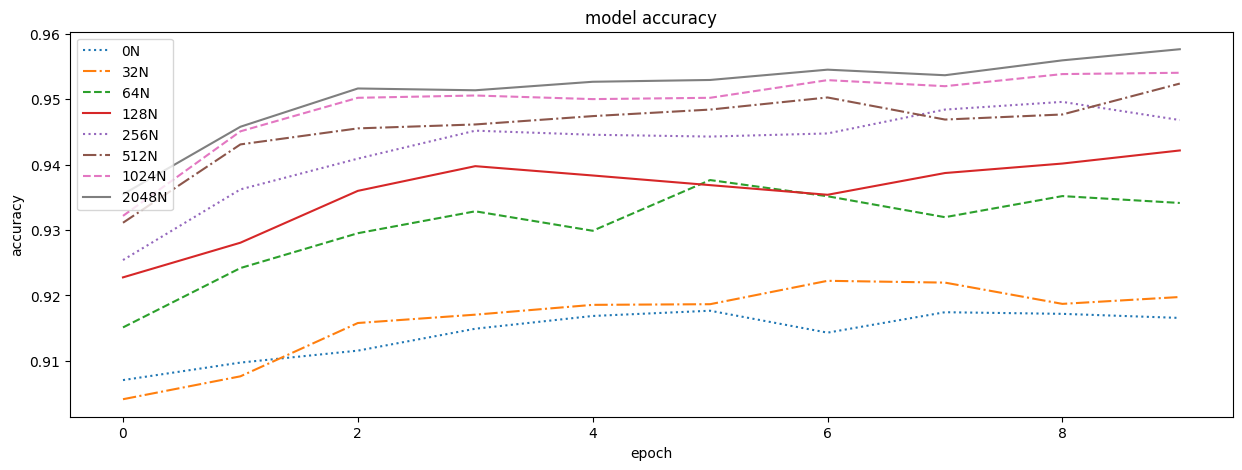

In [ ]:
names = ["0N","32N","64N","128N","256N","512N","1024N","2048N"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a quantidade de neurônios na camada densa que obteve o melhor desempenho foi 2048. Entretanto, será escolhido 512 neurônios para a camada densa, pois acredita-se que o ganho de desempenho em relação à 2048 neurônios não compensa o custo computacional. Sendo assim, essa configuração será mantida nos próximos testes.

## Droupout

Referência:

*   Conceituação - https://www.deeplearningbook.com.br/capitulo-23-como-funciona-o-dropout/
*   Código -



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

O dropout é uma técnica de regularização amplamente empregada no treinamento de redes neurais, ele tem como propósito evitar o overfitting no modelo, isto é, ele evita o fenômeno no qual o modelo se ajusta excessivamente aos dados de treinamento, a fim de gerar melhores generalização para novos dados.
Durante o treinamento com dropout, neurônios das camadas ocultas são selecionadas aleatoriamente e temporariamente inativados, implicando na remoção temporária de suas contribuições para a propagação de sinais e atualização de pesos.

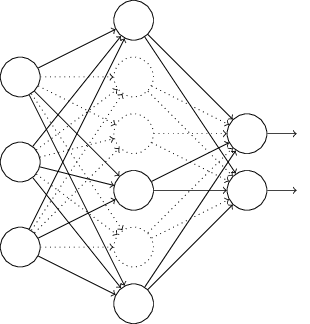

Essa abordagem auxilia na redução da coadaptação entre neurônios, incentivando a rede neural a aprender características mais robustas e independentes dos dados de treinamento.

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Serão comparadas 8 configurações de modelo, em que cada uma possui as seguintes porcentagens
# de dropout: 0%, 10%, 20%, 30%, 40%, 50%, 60%, 70%

nets = 8
model = [0] *nets


for j in range(8): # o modelo j vai ter um dropout de (j*0.1)% ao final de cada camada
    model[j] = Sequential()
    model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
    model[j].add(MaxPool2D())
    model[j].add(Dropout(j*0.1))
    model[j].add(Flatten())
    model[j].add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
    model[j].add(Dropout(j*0.1))
    model[j].add(Dense(10, activation='softmax'))
    model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
names = ["D=0.0","D=0.1","D=0.2","D=0.3","D=0.4","D=0.5","D=0.6","D=0.7"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a porcentagem de dropout que obteve o melhor desempenho foi 30%. Sendo assim, essa configuração será mantida nos próximos testes.

## Batch normalization

A normalização em lote ajuda a lidar com problemas de covariância interna, em que as distribuições das ativações mudam à medida que os parâmetros da rede são atualizados, dificultando o treinamento. Ao estabilizar as ativações, ele permite o uso de taxas de aprendizado mais altas, ajudando a rede generalizar-se melhor para os dados.

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Será comparado duas configurações de modelos, em que a primeira não utiliza a técnica Batch Normalization,
# e a segunda a implementa

nets = 2
model = [0] *nets

# modelo basico
j=0
model[j] = Sequential()
model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))
model[j].add(Flatten())
model[j].add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# batch normalization
j=1
model[j] = Sequential()
model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
model[j].add(BatchNormalization())
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))
model[j].add(Flatten())
model[j].add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model[j].add(BatchNormalization())
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
names = ["basic","basic+BN"]
avalia_calibracao(names)

A partir do gráfico acima, infere-se que a utilização da técnica Batch Normalization resultou em uma perda de desempenho. Portanto, ela não será utilizada na configuração futura.

## Data Augmentation

Data augmentation é uma prática empregada com o intuito de ampliar o tamanho e a diversidade do conjunto de dados de treinamento para resultar em um melhor desempenho do modelo.
Utilizando dos dados de treinamento, ele aplica transformações aleatórias aos dados existentes, gerando exemplos adicionais que possuem semelhanças, mas também diferem dos exemplos originais.

Alguns exemplos de tranformações que são possíveis de obter atráves do Data Augmentation são: rotação, espelhamento, translação, zoom, ajuste de brilho e outros.
Ao introduzir essas transformações, aumenta-se a variabilidade dos dados de treinamento, possibilitando que o modelo generalize mais eficazmente para diferentes condições e variações encontradas nos dados de teste.

In [ ]:
# Construção das redes neurais convolucionais que serão comparadas
# Será comparado duas configurações de modelos, em que o primeiro não utiliza a ténica Data Augmentation
# e a segunda a implementa

nets = 2
model = [0] *nets

# modelo basico
j=0
model[j] = Sequential()
model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))
model[j].add(Flatten())
model[j].add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

# modelo para data augmentation
j=1
model[j] = Sequential()
model[j].add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
model[j].add(MaxPool2D())
model[j].add(Dropout(0.3))
model[j].add(Flatten())
model[j].add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
model[j].add(Dropout(0.3))
model[j].add(Dense(10, activation='softmax'))
model[j].compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

Para fazer a comparação dos dois modelos, foi necessário fazer alterações na função de calibração original. Sendo assim, foi criada a seguinte função que testa e compara 2 configurações de modelos, em que o primeiro não implementa o Data Augmentation, enquanto o segundo implementa:

In [ ]:
def avalia_calibracao_data_aug(names):


    nets = 2 # numero de redes é equivalente aos nomes dados para cada tipo de rede

    # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION

    X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.333)

    k_folds = 3 # quantidade de folds

    history = [0] * nets * k_folds # quantidade de modelos que serao criados

    mean_val_hist = [] # lista que vai armazenar as acuracias medias de cada epoca de um determinada configuracao de modelo

    epochs = 10 # quantidade de epocas

    kfold = KFold(k_folds, shuffle=True, random_state=1)

    curr_model = -1 # numero do modelo atual, que vai de 0 até [(nets * k_folds) - 1]

    for config_modelo in range(nets - 1): # iteracao atraves de cada uma das j configuracoes de modelos


        curr_mean_val = np.array([0.0] * epochs) # vetor que vai armazenar na posicao "x" a soma das (k_folds) acuracias da configuracao (j) que tambem estao na posicao "x"

      # enumeracao dos k splits
        for train_ix, test_ix in kfold.split(X_train2):

            curr_model += 1 # numero do modelo atual que sera construido

          # select rows for train and test (validation)
            trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

          # treinamento da rede do modelo atual
            history[curr_model] = model[config_modelo].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=2)

            if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

                total_acc = [] # acuracias obtidas no treino
                total_acc_val = [] # acuracias obtidas na validacao

                for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                    total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                    total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                    curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

                print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                  names[config_modelo],epochs,max(total_acc),max(total_acc_val)))

        curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
        curr_mean_val = list(curr_mean_val)
        mean_val_hist.append(curr_mean_val)



    # CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
    datagen = ImageDataGenerator(
            rotation_range=10,
            zoom_range = 0.1,
            width_shift_range=0.1,
            height_shift_range=0.1)

    # CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION

    #x_train, y_train, x_test, y_test

    # nomes de cada configuracao de modelo

    config_modelo = 1

    curr_mean_val = np.array([0.0] * epochs)

    curr_model = 2

    # enumeracao dos k splits
    for train_ix, test_ix in kfold.split(X_train2):

        curr_model += 1 # numero do modelo atual que sera construido

        # select rows for train and test (validation)
        trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

        # treinamento da rede do modelo atual
        #history[curr_model] = model[j].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=0)

        history[curr_model] = model[j].fit(datagen.flow(trainX,trainY, batch_size=64),
        epochs = epochs, steps_per_epoch = trainX.shape[0]//64,
        validation_data = (testX,testY), callbacks=[annealer], verbose=2)


        if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

            total_acc = [] # acuracias obtidas no treino
            total_acc_val = [] # acuracias obtidas na validacao

            for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual
                curr_mean_val += np.array(history[curr_model - k].history['val_accuracy']) # incrementa com as metricas de cada modelo

            print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                names[j],epochs,max(total_acc),max(total_acc_val)))

    curr_mean_val  = curr_mean_val / k_folds # divide para calcular a media
    curr_mean_val = list(curr_mean_val)
    mean_val_hist.append(curr_mean_val)

    # PLOT ACCURACIES
    plt.figure(figsize=(15,5))
    for i in range(nets):
        plt.plot(mean_val_hist[i],linestyle=styles[i])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(names, loc='upper left')
    plt.show()

Por fim, a função criada acima será utilizada:

In [ ]:
names = ["basic","basic+DA"]
avalia_calibracao_data_aug(names)

A partir do gráfico acima, infere-se que o uso da técnica Data Augmentation resultou em um desempenho inferior em comparação com o modelo base. Portanto, essa técnica não será utilizada para a construção do modelo final.

# Comparação do modelo base com modelo final

Nesta seção será comparado o desempenho do modelo base (inicial) em comparação com o modelo final, que foi obtido a partir dos testes de calibração feitos até então. Como função que instancia o modelo base já foi criada (define_basic_model), será criada uma função que instancia uma configuração do modelo final também:

In [ ]:
def define_final_model():

  model = Sequential()
  model.add(Conv2D(64,kernel_size=5,activation='relu',input_shape=(28,28,1), strides=1, kernel_initializer='he_uniform', padding='same'))
  model.add(MaxPool2D())
  model.add(Dropout(0.3))
  model.add(Flatten())
  model.add(Dense(512, activation='relu', kernel_initializer='he_uniform'))
  model.add(Dropout(0.3))
  model.add(Dense(10, activation='softmax'))
  model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])

  return model

Agora será feito a comparação entre os 2 modelos.

In [ ]:
model = [0] * 2
model[0] = define_basic_model()
model[1] = define_final_model()

In [ ]:
names = ["modelo base","modelo final"]
avalia_calibracao(names) # ou outra funcao caso utilizemos o data augmentation

A partir do gráfico acima, infere-se que ...

Ainda será feita outra comparação a partir da função run_test:

In [ ]:
run_test(define_basic_model())

In [ ]:
run_test(define_final_model())

Os gráficos acima permitem inferir que...

Portanto, conclui-se que o modelo final possui um desempenho significativamente superior em relação ao modelo base. Sendo assim, ele será utilizado para fazer a predição dos dados.

# Predição

In [ ]:
# TRAIN OUR BEST NET MORE
epochs = 20
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** (x+epochs))

model[1].fit(x_train, y_train, batch_size=64, epochs = 25, callbacks=[annealer], steps_per_epoch = x_train.shape[0]//64, verbose=2)

#model[4].fit_generator(datagen.flow(X_train,Y_train, batch_size=64), epochs = 25,
#    steps_per_epoch = X_train.shape[0]//64, callbacks=[annealer], verbose=0)

# SUBMIT TO KAGGLE
results = model[1].predict(x_test)
results = np.argmax(results,axis = 1)
results

## Acurácia

In [ ]:
y_test = np.argmax(y_test,axis = 1)
y_test

In [ ]:
acc = accuracy_score(y_test, results)
print(f'Acurácia = {round(acc, 2) * 100}%')

In [ ]:
# VALIDACAO DA REDE BASICA

# CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION

#x_train, y_train, x_test, y_test

X_train2, X_val2, Y_train2, Y_val2 = train_test_split(x_train, y_train, test_size = 0.333)

k_folds = 3 # quantidade de folds

history = [0] * nets * k_folds # quantidade de modelos que serao criados

names = ["basic+BN"] # nomes de cada configuracao de modelo

epochs = 20 # quantidade de epocas

kfold = KFold(k_folds, shuffle=True, random_state=1)

curr_model = -1 # numero do modelo atual, que vai de 0 até [(nets * k_folds) - 1]

for j in range(nets - 1): # iteracao atraves de cada uma das j configuracoes de modelos

    # enumeracao dos k splits
    for train_ix, test_ix in kfold.split(X_train2):

        curr_model += 1 # numero do modelo atual que sera construido

        # select rows for train and test (validation)
        trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

        # treinamento da rede do modelo atual
        history[curr_model] = model[j].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=0)
        # history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)


        if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

            total_acc = [] # acuracias obtidas no treino
            total_acc_val = [] # acuracias obtidas na validacao

            for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

                total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
                total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual

            print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
                names[j],epochs,max(total_acc),max(total_acc_val)))

In [ ]:
# VALIDACAO DA REDE COM DATA AUGMENTATION

# CREATE MORE TRAINING IMAGES VIA DATA AUGMENTATION
datagen = ImageDataGenerator(
        rotation_range=10,
        zoom_range = 0.1,
        width_shift_range=0.1,
        height_shift_range=0.1)

# CRIAÇÃO DO CONJUNTO DE VALIDAÇÃO APLICANDO A CROSS VALIDATION

#x_train, y_train, x_test, y_test

names = ["basic+BN+DA"] # nomes de cada configuracao de modelo

epochs = 20 # quantidade de epocas

kfold = KFold(k_folds, shuffle=True, random_state=1)

j = nets-1

# enumeracao dos k splits
for train_ix, test_ix in kfold.split(X_train2):

    curr_model += 1 # numero do modelo atual que sera construido

    # select rows for train and test (validation)
    trainX, trainY, testX, testY = X_train2[train_ix], Y_train2[train_ix], X_train2[test_ix], Y_train2[test_ix]

    # treinamento da rede do modelo atual
    history[curr_model] = model[j].fit(trainX, trainY, batch_size=80, epochs = epochs, validation_data = (testX,testY), callbacks=[annealer], verbose=0)
    # history = model.fit(trainX, trainY, epochs=10, batch_size=32, validation_data=(testX, testY), verbose=0)


    if ((curr_model + 1) % k_folds) == 0: # terminou de analisar todos os k folds para uma configuracao de modelo, agora é necessário escolher o melhor modelo da configuracao analisada entre os k modelos

        total_acc = [] # acuracias obtidas no treino
        total_acc_val = [] # acuracias obtidas na validacao

        for k in range(k_folds): # vamos voltar para analisar cada um dos modelos criados para a configuracao atual

            total_acc += history[curr_model - k].history['accuracy'] # adiciona todas as acuracias (treinamento) do modelo atual na lista de acuracia da configuracao atual
            total_acc_val += history[curr_model - k].history['val_accuracy'] # adiciona todas as acuracias (validacao) do modelo atual na lista de acuracia da configuracao atrual

        print("CNN {0}: Epochs={1:d}, Train accuracy={2:.5f}, Validation accuracy={3:.5f}".format(
            names[j],epochs,max(total_acc),max(total_acc_val)))



In [ ]:
# PLOT ACCURACIES
plt.figure(figsize=(15,5))
for i in range(nets):
    plt.plot(history[i].history['val_acc'],linestyle=styles[i])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(names, loc='upper left')
#axes = plt.gca()
#axes.set_ylim([0.98,1])
plt.show()

# Considerações Finais

D, E e F